In [ ]:
import numpy as np
# from tqdm import tdqm, trange

import torch
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import os
from PIL import Image

from tqdm import tqdm, trange
import torch

import torchvision.transforms as transforms



np.random.seed(0)
torch.manual_seed(0)
print(torch.backends.mps.is_available())
mps_device = torch.device("mps")
print(mps_device)

In [ ]:
import PIL
from PIL import Image
import numpy as np
import os
import random 
import pandas as pd
# open method used to open different extension image file
TRAIN_DATA_FOLDER = "../datasets/MRI/data/mri_data_full/train"
train_tumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/tumor/')
num_train_tumor_files = len(train_tumor_filenames)
print("Number of Training Tumor Files: ", num_train_tumor_files)

train_notumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/notumor/')
num_train_notumor_files = len(train_notumor_filenames)
print("Number of Training No Tumor Files: ", num_train_notumor_files)

## Transformer Model Architecture
![Transformer Model](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

## Resizing Image

### Formula [e.g (N,1,28,28)] 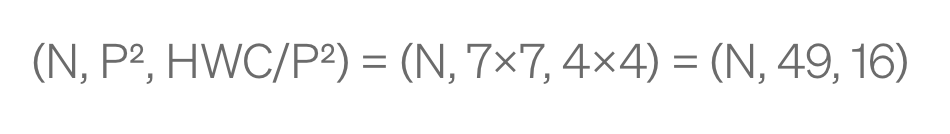
![Reshaping Image](https://miro.medium.com/v2/resize:fit:822/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)


### Positional Embedding
![Positional Embedding Formula](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lpRYHE0XjVkxRVKFrWkzuw.png)

In [ ]:
# from torchvision.transforms import ToPILImage
# import matplotlib.pyplot as plt

# def main():

#     IMAGE_SIZE = (1,128,128)
#     NUM_PATCHES = 32

#     train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
#     train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

#     test_dataset = MRIDataset('../datasets/MRI/test/', transform=ToTensor(),image_shape = IMAGE_SIZE[1])
#     test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=128)

#     # Get one batch (single image and label)
#     for images, labels in train_loader:
#         # Extract the first image and label
#         image = images[0]  # Tensor shape: (C, H, W)
#         label = labels[0]
        
#         if label == 1:
#             # Convert the tensor back to a PIL image for display
#             to_pil = ToPILImage()
#             image_pil = to_pil(image)

#             # Display the image
#             plt.imshow(image_pil)
#             plt.title(f"Label: {label}")
#             plt.axis('off')
#             plt.show()
#             break

#     for images, labels in train_loader:
#         # Extract the first image and label
#         image = images[0]  # Tensor shape: (C, H, W)
#         label = labels[0]

#         if label == 0:
#             # Convert the tensor back to a PIL image for display
#             to_pil = ToPILImage()
#             image_pil = to_pil(image)

#             # Display the image
#             plt.imshow(image_pil)
#             plt.title(f"Label: {label}")
#             plt.axis('off')
#             plt.show()
#             break

#     print(train_loader)
#     device = torch.device("cuda" if torch.cuda.is_available() else "mps")
#     # print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available else "")
#     model = MyViT(IMAGE_SIZE, n_patches=NUM_PATCHES, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

#     N_EPOCHS = 5
#     LR = 0.005
    
#     # Training Loop
#     optimizer = Adam(model.parameters(),lr = LR)
#     scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#     criterion = CrossEntropyLoss()
#     for epoch in trange(N_EPOCHS,desc="Training"):
#         train_loss = 0.0
#         for batch in tqdm(train_loader,desc=f"Epoch{epoch+1} in training", leave=False):
#             x,y = batch
#             # print(y.shape)
#             x,y = x.to(device),y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat,y)
#             train_loss += loss.detach().cpu().item()/len(train_loader)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         scheduler.step()
#         print(f"Epoch {epoch+1}/{N_EPOCHS} loss: {train_loss:.2f}")

#     with torch.no_grad():
#         correct,total = 0,0
#         test_loss = 0.0
#         for batch in tqdm(test_loader,desc="Testing"):
#             x,y = batch
#             x,y = x.to(device),y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat,y)
#             test_loss += loss.detach().cpu().item()/len(test_loader)

#             correct += torch.sum(torch.argmax(y_hat,dim=1) == y).detach().cpu()
#             total += len(x)
#         print(f"Test loss: {test_loss:.2f}")
#         print(f"Test accuracy: {correct / total * 100:.2f}%")




# Multi-Self Attention Class

In [ ]:
# from MyViT.ViT import * 
# from MyViT.utils import MRIDataset,get_positional_embeddings,patchify

# if __name__ == '__main__':
#     main()

# Causal AI Implementation


Observing Causal Variational Encoder Behavior


In [ ]:
# import torch
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader
# from torchvision.transforms import ToTensor
# from CausalVAE.causal_vae import CausalVAE
# from MyViT.utils import MRIDataset  # Assuming MRIDataset is defined in your utils.py

# # Assume IMAGE_SIZE is defined somewhere in your code; for example:
# # IMAGE_SIZE = (1, 224, 224)  -> grayscale image with height and width of 224 pixels
# image_size = 224  # You can set this based on IMAGE_SIZE[1]
# input_dim = image_size * image_size  # For grayscale images

# # Define the dimensions for the causal VAE
# z_dim = 50
# hidden_dim = 100

# # Instantiate the causal VAE model
# model = CausalVAE(input_dim=input_dim, z_dim=z_dim, hidden_dim=hidden_dim)
# model.eval()  # Set the model to evaluation mode

# # Load your MRI dataset using MRIDataset from utils.py
# train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(), image_shape=image_size)
# train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=128)

# # Get a random batch from the train_loader
# data_iter = iter(train_loader)
# images, labels = next(data_iter)

# # Assuming images are of shape (batch_size, channels, height, width)
# # If the images are grayscale, channels=1; we flatten the images for the VAE
# batch_size = images.size(0)
# images_flat = images.view(batch_size, -1)  # shape: (batch_size, input_dim)

# # Pass the images through the causal VAE to obtain reconstructions and latent variables
# with torch.no_grad():
#     reconstructions, z, z_mu, z_logvar = model(images_flat)

# # Helper function to display images
# def show_images(imgs, title, image_shape=(image_size, image_size), n=4):
#     # Only use the first n images
#     imgs = imgs[:n]
#     imgs = imgs.view(-1, *image_shape).cpu()
#     batch = imgs.size(0)
#     fig, axes = plt.subplots(1, batch, figsize=(3 * batch, 3))
#     for i in range(batch):
#         axes[i].imshow(imgs[i], cmap='gray')
#         axes[i].axis('off')
#     plt.suptitle(title)
#     plt.show()

# # Visualize the original and reconstructed images
# show_images(images_flat, "Original MRI Images", image_shape=(image_size, image_size))
# show_images(reconstructions, "Reconstructed MRI Images", image_shape=(image_size, image_size))

# import torch
# from CausalTransformer.causal_transformer import HybridModel
# if __name__ == "__main__":
#     # Define parameters for MyViT
#     vit_params = {
#         'chw': (1, 224, 224),  # For example, grayscale images of 224x224
#         'n_patches': 8,
#         'n_blocks': 2,
#         'hidden_d': 64,        # Increased hidden dimension for better representation
#         'n_heads': 2,
#         'out_d': 10            # This is not used in the hybrid model since we fuse later
#     }
#     # For the VAE, if using raw images of 224x224:
#     vae_input_dim = 224 * 224

#     # Instantiate the hybrid model
#     model = HybridModel(vit_params, vae_input_dim, vae_z_dim=50, vae_hidden_dim=400, num_classes=2)
#     # Example input: a batch of MRI images (batch_size, channels, height, width)
#     dummy_images = torch.randn(4, 1, 224, 224)
#     outputs = model(dummy_images, return_all=True)
#     print("Hybrid Model Output:", outputs)

# Step 3: Training, Evaluation, and Analysis

1. Define the Loss Functions

We have three components in our loss:
	•	Classification Loss: Measures how well the model predicts tumor vs. non-tumor. We’ll use Cross Entropy Loss.
	•	Reconstruction Loss: Measures how close the VAE’s reconstruction is to the original image. For images normalized between 0 and 1, Binary Cross Entropy (BCE) works well.
	•	KL Divergence Loss: Regularizes the latent distribution  z  to be close to a standard normal distribution.

The total loss is given by:


$$
\text{Total Loss} = \text{Classification Loss} + \lambda \times (\text{Reconstruction Loss} + \text{KL Divergence Loss})
$$


where $$\lambda$$ is a hyperparameter controlling the weight of the VAE losses.

In [ ]:
# from PIL import Image

# img = Image.open("../datasets/MRI/data/train/tumor/Tr-me_0010.jpg")  # path to your file
# print(img.size)  # returns (width, height) in pixels

In [3]:
import torch
import torch.nn.functional as F
from torch.optim import Adam,lr_scheduler
from tqdm import tqdm, trange
from MyViT.utils import MRIDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from CausalVAE.causal_vae import CausalVAE
from CausalTransformer.causal_transformer import HybridModel
import matplotlib.pyplot as plt
from MyViT.utils import MRIDataset  # Assuming MRIDataset is defined in your utils.py

device = "cpu"
# device = torch.device("cpu" if torch.cuda.is_available() else "mps")
print("Using device: ", device)
# Define the image size constant (e.g., 224 for 224x224 images)
IMAGE_SIZE = 256
BATCH_SIZE = 32
train_dataset = MRIDataset('../datasets/MRI/data/train/', transform=ToTensor(),image_shape = IMAGE_SIZE)
train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,num_workers=0)

test_dataset = MRIDataset('../datasets/MRI/data/test/', transform=ToTensor(),image_shape = IMAGE_SIZE)
test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE,num_workers=0)


# --- Step 1: Define Loss Functions and Hyperparameters ---


 
def kl_divergence_loss(z_mu, z_logvar):
    return -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())

N_EPOCHS = 50
lambda_vae = 0.01
learning_rate = 1e-2

NUM_PATCHES = 32
N_BLOCKS = 2
HIDDEN_D = 64
N_HEADS = 2
OUT_D = 10
# --- Step 2: Instantiate Your Hybrid Model & Optimizer ---

# Example ViT config using IMAGE_SIZE
vit_config = {
    'chw': (1, IMAGE_SIZE, IMAGE_SIZE),
    'n_patches': NUM_PATCHES,
    'n_blocks': N_BLOCKS,
    'hidden_d': HIDDEN_D,
    'n_heads': N_HEADS,
    'out_d': OUT_D  # Not used in final classification as we override with fusion_layer
}

vae_input_dim = IMAGE_SIZE * IMAGE_SIZE  # For grayscale images

# Instantiate your HybridModel (assumed to be imported)
model = HybridModel(
    vit_config,
    vae_input_dim=vae_input_dim,
    vae_z_dim=50,
    vae_hidden_dim=400,
    num_classes=2,
    batch_size = BATCH_SIZE
).to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
classification_loss_fn = torch.nn.CrossEntropyLoss()
reconstruction_loss_fn = torch.nn.BCELoss(reduction='mean')
   
# --- Step 3: Define an Accuracy Evaluation Function ---

def evaluate_accuracy(model, data_loader, device):
    model.eval()  # set model to evaluation mode
    correct_total = 0
    samples_total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # We only need logits for accuracy
            logits = model(images)
            _, predicted_classes = torch.max(logits, dim=1)

            correct_total += (predicted_classes == labels).sum().item()
            samples_total += labels.size(0)

    return correct_total / samples_total if samples_total > 0 else 0.0




Using device:  cpu


In [4]:
import time
def test_function(train_dataset,test_dataset,train_loader,model,Device):
    print(f"Using device: {device}")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")


    x, y = next(iter(train_loader))  # Get a single batch
    x, y = x.to(Device), y.to(Device)
    print(f"Batch shape: {x.shape}, Labels: {y}")
    print("Testing forward pass...")
    try:
        time_start = time.time()
        logits, x_recon, z_mu, z_logvar = model(x, return_all=True)
        total_time = time.time()-time_start 
        print(f"Device: {Device} | Logits Shape: {logits.shape}, Reconstructed Shape: {x_recon.shape} | Time Taken: {total_time}")
    except Exception as e:
        print("Forward pass failed:", str(e))

test_function(train_dataset,test_dataset,train_loader,model,Device=device)
# test_function(train_loader,model.to('cpu'))

Using device: cpu
Train dataset size: 2934
Test dataset size: 711
Batch shape: torch.Size([32, 1, 256, 256]), Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 0, 1])
Testing forward pass...
Device: cpu | Logits Shape: torch.Size([32, 2]), Reconstructed Shape: torch.Size([32, 65536]) | Time Taken: 0.584326982498169


In [5]:

# --- Step 4: Training Loop with Periodic Accuracy Checks ---

train_losses = []
train_accuracies = []

model.train()
for epoch in trange(N_EPOCHS,desc="Training"):
    
    epoch_loss = 0.0

    for batch in tqdm(train_loader,desc=f"Epoch{epoch+1} in training", leave=False):
        
        x,y = batch
        x,y = x.to(device),y.to(device)
        optimizer.zero_grad()
        # Forward pass, returning VAE outputs for reconstruction & KL losses
        logits, x_recon, z_mu, z_logvar = model(x, return_all=True)
        # Classification Loss
        class_loss = classification_loss_fn(logits, y.long())

    
        # Reconstruction Loss: flatten images using IMAGE_SIZE
        batch_size = x.size(0)
        images_flat = x.view(batch_size, -1)
        recon_loss = reconstruction_loss_fn(x_recon, images_flat)

        # KL Divergence Loss
        kl_loss = kl_divergence_loss(z_mu, z_logvar)

        # Combined Loss
        total_loss = class_loss + lambda_vae * (recon_loss + kl_loss)
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    scheduler.step()
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Evaluate accuracy on the training set
    train_acc = evaluate_accuracy(model, train_loader,device='mps')
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{N_EPOCHS}] | Loss: {avg_epoch_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    if train_acc > 0.95:
        break
# --- Optional: Plot Training Loss and Accuracy ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

Training:   0%|          | 0/50 [00:01<?, ?it/s]


RuntimeError: all elements of input should be between 0 and 1

In [ ]:
# To save your model weights:
torch.save(model.state_dict(), "hybrid_model_weights.pth")


NUM_PATCHES = 16
N_BLOCKS = 2
HIDDEN_D = 8
N_HEADS = 2
OUT_D = 10
# --- Step 2: Instantiate Your Hybrid Model & Optimizer ---

# Example ViT config using IMAGE_SIZE
vit_config = {
    'chw': (1, IMAGE_SIZE, IMAGE_SIZE),
    'n_patches': NUM_PATCHES,
    'n_blocks': N_BLOCKS,
    'hidden_d': HIDDEN_D,
    'n_heads': N_HEADS,
    'out_d': OUT_D  # Not used in final classification as we override with fusion_layer
}

vae_input_dim = IMAGE_SIZE * IMAGE_SIZE  # For grayscale images

# Instantiate your HybridModel (assumed to be imported)
model = HybridModel(
    vit_config,
    vae_input_dim=vae_input_dim,
    vae_z_dim=50,
    vae_hidden_dim=400,
    num_classes=2,
    batch_size = BATCH_SIZE
).to(device)
# Later, to load these weights:
# model = HybridModel(vit_config, vae_input_dim, vae_z_dim=50, vae_hidden_dim=400, num_classes=2)
model.load_state_dict(torch.load("hybrid_model_weights.pth"))

In [ ]:
test_acc = evaluate_accuracy(model, test_loader,device='cpu')
print(test_acc*100)

In [ ]:
# --- Step 5: Visualize Reconstructions Using IMAGE_SIZE ---

def show_images(imgs, title,labels, image_shape=(IMAGE_SIZE, IMAGE_SIZE), n=4):
    imgs = imgs[:n]
    imgs = imgs.view(-1, *image_shape).cpu()
    batch = imgs.size(0)
    labels = labels[:n]
    
    fig, axes = plt.subplots(1, batch, figsize=(3 * batch, 3))
    for i in range(batch):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
        axes[i].title.set_text(f"{"Tumor : 1" if labels[i].item() == 1 else "No Tumor : 0"}")
    plt.suptitle(title)
    plt.show()

# Get a batch from the train_loader for visualization
data_iter = iter(test_loader)
x, y = next(data_iter)
x = x.to(device)
y = y.to(device)
batch_size = x.size(0)
images_flat = x.view(batch_size, -1)

logits,_,_,_ = model(x,return_all=True)
predicted = torch.max(logits, dim=1)
# torch.cat(predicted.indices)
with torch.no_grad():
    x_recon, _,_, _= model.causal_vae(images_flat)

print(f"Image Size: {IMAGE_SIZE}")
show_images(images_flat, "Original MRI Images",labels = y, image_shape=(IMAGE_SIZE, IMAGE_SIZE), n=10)
show_images(x_recon, "Reconstructed MRI Images", labels = predicted.indices ,image_shape=(IMAGE_SIZE, IMAGE_SIZE), n=10)